# curves experimental design -- full notebook

In [1]:
import os
import sys
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as log_progress
from tqdm.notebook import trange

import warnings
warnings.filterwarnings("ignore")

In [2]:
# set seed for reproducibility
SEED = 10 
random.seed(SEED)
np.random.seed(seed=SEED)

In [3]:
# create output directory
#output_path = './online_pilot_007'
#if not os.path.exists(output_path):
#    print(f'making path: {output_path}')
#    os.mkdir(output_path)

## target curve generation

In [8]:
from src.core import make_knot_grid, sample_knots, make_curve
from src.visualization import pretty_picture_of_curve
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import auc
import pickle as pk

In [9]:
## set initial values for curve generation
low, high  = -1, 1
size_of_knot_grid = 10
max_knot_number = 10 
resolution_of_curves = 100
curves_per_knot_number = 1000
total_curves = (max_knot_number-2)*curves_per_knot_number

In [10]:
## create knot grid
knot_grid = make_knot_grid(size_of_knot_grid, low, high)

In [11]:
def generate_target_curves(max_knot_number, resolution_of_curves, curves_per_knot_number):
    ##generate a bunch of curves as data for PCA analysis
    total_curves = (max_knot_number-2)*curves_per_knot_number
    print('generating %d curves' %(total_curves))
    X,Y = np.zeros((total_curves,resolution_of_curves)), np.zeros((total_curves,resolution_of_curves))
    n_knots = np.ones(total_curves) *-1
    counter = 0
    for num_knots in log_progress(range(2, max_knot_number)):
        for c in range(curves_per_knot_number):
            knots = sample_knots(knot_grid, num_knots,closed=False)
            xy,_ = make_curve(knots,resolution_of_curves, kind='quadratic')
            X[counter, :] = xy[:,0]
            Y[counter, :] = xy[:,1]
            n_knots[counter] = num_knots
            counter+=1
    XY = np.concatenate((X,Y),axis = 1)#   
    return XY, n_knots

def fit_PCA(XY, plot=True, max_knot_number=0):
    ##PCA on curves: should decay to zero at ~ 2 x max_knot_number
    pca = PCA()
    pca.fit(XY)
    if plot:
        plt.figure(figsize= (8,5))
        # plt.yscale('log')
        plt.xticks(ticks = np.arange(0,max_knot_number*2+2,4)) 
        plt.xlabel('# of PCs')
        plt.ylabel('fraction of variance explained')
        plt.plot(pca.explained_variance_ratio_[:max_knot_number*2+2], )
    return pca

In [13]:
# generate large data set, fit pca 
XY, n_knots = generate_target_curves(max_knot_number, resolution_of_curves, curves_per_knot_number)

generating 8000 curves


  0%|          | 0/8 [00:00<?, ?it/s]

array([[ 0.77777778,  0.7687991 ,  0.75982043, ..., -0.12457912,
        -0.11784512, -0.11111111],
       [-0.33333333, -0.33782267, -0.34231201, ..., -0.34680135,
        -0.34006734, -0.33333333],
       [-1.        , -0.98428732, -0.96857464, ...,  0.75084175,
         0.76430976,  0.77777778],
       ...,
       [-0.33333333, -0.19973069, -0.07383195, ..., -1.06926914,
        -1.03797284, -1.        ],
       [ 0.77777778,  0.85842587,  0.92805141, ...,  0.29019555,
         0.30968551,  0.33333333],
       [ 1.        ,  0.76081382,  0.54158099, ..., -0.02939434,
         0.14141196,  0.33333333]])

In [15]:
with open('../design/online_pilot_007/XY.npy', 'wb') as f:
    np.save(f, XY)

In [41]:
# save pca object out |
pk.dump(pca, open(output_path + '/pca.pkl', 'wb'))

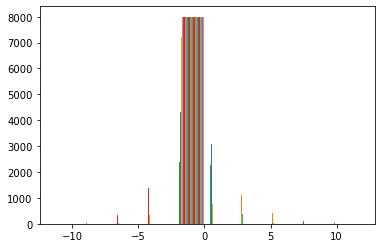

In [42]:
## compute mean projection onto each axis
all_projections = XY @ pca.components_.T
_=plt.hist(all_projections)
all_projections_mean = np.mean(all_projections, axis=0)
pca.all_projections_mean_ = all_projections_mean

### compute rate distortion profile for single curve at each # of knot points

In [43]:
from src.rate_distortion import compute_rd_correlation
from src.visualization import rd_plot

In [44]:
# check the rd curve choosing one curve for every # of knot points
curve_set_indices = curves_per_knot_number*(np.array(range(2, max_knot_number))-1)-1
curves = [XY[idx,:] for idx in curve_set_indices]

No handles with labels found to put in legend.


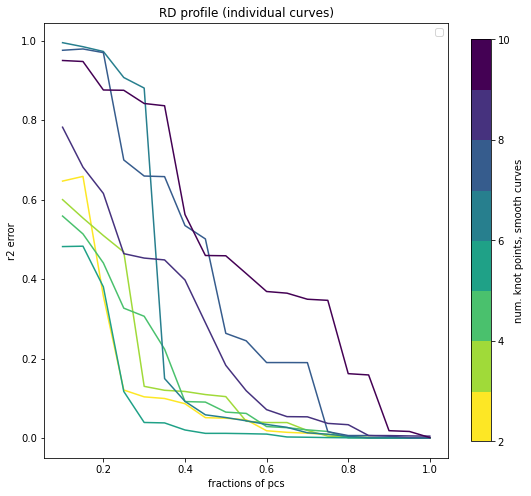

In [45]:
distortion = compute_rd_correlation(curves, pca, 'component', 'r2')
rd_plot(distortion, max_knot_number, ylabel='r2 error', title='RD profile (individual curves)')

### compute rd profile for all target curves

In [46]:
from src.rate_distortion import reconstruction, distortion, reshape, smooth_distortions

In [47]:
# batch size for saving distortions
batch_size = 4000
curves_per_batch = (curves_per_knot_number * (max_knot_number-2)) / batch_size
print(f'curves per batch: {curves_per_batch}')

curves per batch: 2.0


In [19]:
dist_path = output_path + '/distortions'
if not os.path.exists(dist_path):
    print(f'making path: {dist_path}')
    os.mkdir(dist_path)

making path: ./online_pilot_007/distortions


In [20]:
# compute rd profile for all generated curves
# these will get average across number of knot points
d_kind = 'r2'
counter = 0
batch_number = 0
d = np.zeros((batch_size, pca.n_components_))

for idx in trange(total_curves):
    xy = XY[idx,:]
    for npcs in range(pca.n_components_):     
        recon = reconstruction(xy, pca, npcs, mean_fill=True)
        recon_curve = reshape(recon)
        curve = reshape(xy)
        d[counter%batch_size, npcs] = distortion(recon, xy, kind=d_kind) 
        
    if (counter+1) % batch_size == 0:
        # save data and reset distortions
        print(f'saving batch: {batch_number}')
        np.savetxt(f'{dist_path}/distortions_{batch_number}.txt', d, delimiter=',')
        batch_number+=1
        d = np.zeros((batch_size, pca.n_components_))
        
    counter +=1 

  0%|          | 0/8000 [00:00<?, ?it/s]

saving batch: 0
saving batch: 1


In [21]:
# load distortions into memory
n_batches = int((curves_per_knot_number * (max_knot_number-2)) / batch_size)
distortions = np.concatenate([np.loadtxt(f'{dist_path}/distortions_{i}.txt', delimiter=',') for i in range(n_batches)])
distortions.shape

(8000, 200)

In [22]:
# average distortions over number of knots points
x = [i for i in range(0, total_curves, curves_per_knot_number)]
y = [i for i in range(curves_per_knot_number, total_curves+1, curves_per_knot_number)]
slices = list(zip(x, y))
average_distortions=np.zeros((max_knot_number-2, 2*resolution_of_curves))
for i, (start,stop) in enumerate(slices):
    average_distortions[i] = distortions[start:stop].mean(axis=0)
    
average_distortions.shape

(8, 200)

In [23]:
np.savetxt(f'{dist_path}/average_distortions_r2.txt', average_distortions, delimiter=',')

No handles with labels found to put in legend.


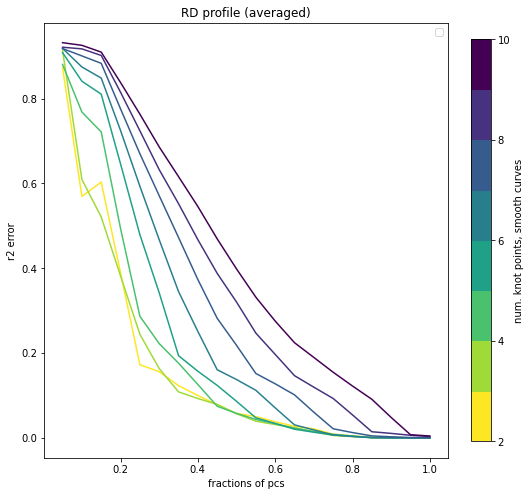

In [24]:
rd_plot(average_distortions, max_knot_number, ylabel='r2 error', title='RD profile (averaged)')

No handles with labels found to put in legend.


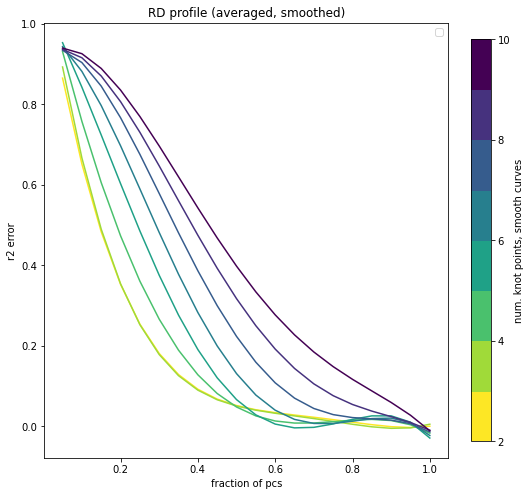

In [25]:
from src.rate_distortion import smooth_distortions
_ = smooth_distortions(average_distortions, max_knot_number, 4, ylabel='r2 error', title='RD profile (averaged, smoothed)')

## select curves based on average rd curve 

In [26]:
from src.visualization import pretty_picture_of_curve_ax

In [27]:
def get_n_lowest_values(ls, n):
    indicies = sorted(range(len(ls)), key=lambda sub: ls[sub])[:n]
    values = [ls[x] for x in indicies]
    return indicies, values

In [28]:
n_curves_per_complexity = 25

curves_sliced = []
distortions_sliced = []
x = [i for i in range(0, total_curves, curves_per_knot_number)]
y = [i for i in range(curves_per_knot_number, total_curves+1, curves_per_knot_number)]
slices = list(zip(x, y))
for i, (start,stop) in enumerate(slices):
    curves_sliced.append(XY[start:stop,:])
    distortions_sliced.append(distortions[start:stop])

min_indicies_per_slice = []
avg_curves = []
avg_curves_distortions = []
    
for curves_slice, distortions_slice, avg_distortions in zip(curves_sliced, distortions_sliced, average_distortions):
    diff = np.absolute(distortions_slice - avg_distortions).sum(axis=1)
    indicies,_ = get_n_lowest_values(diff, n_curves_per_complexity)
    avg_curves.append([curves_slice[x] for x in indicies])
    avg_curves_distortions.append([distortions_slice[x] for x in indicies])
    min_indicies_per_slice.append(indicies)

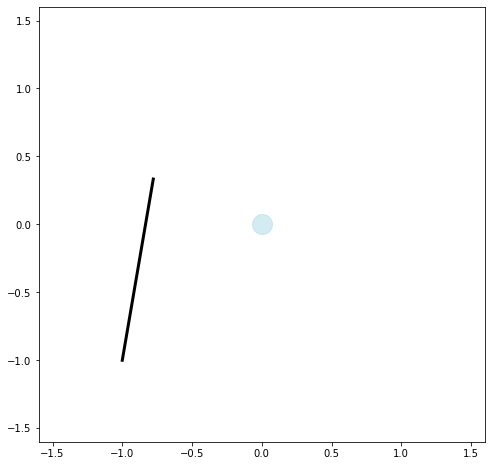

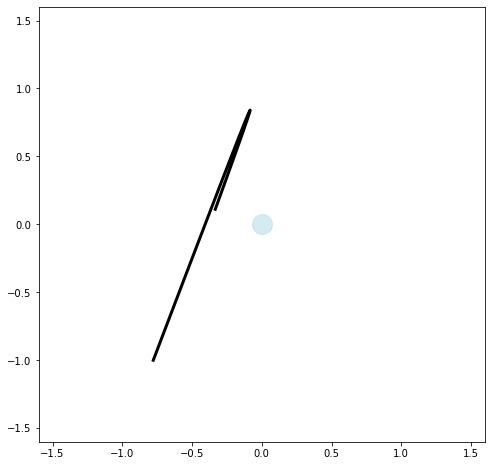

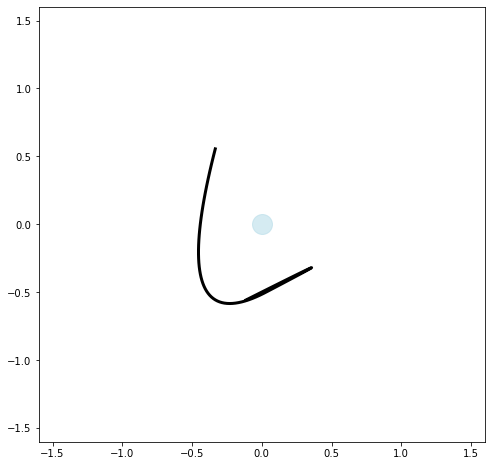

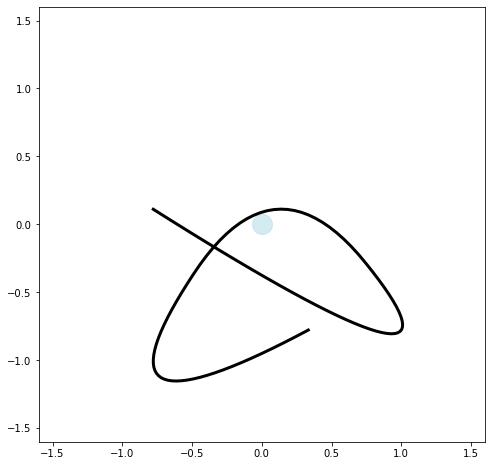

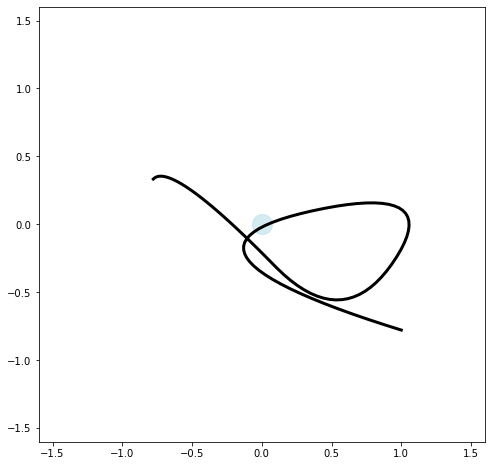

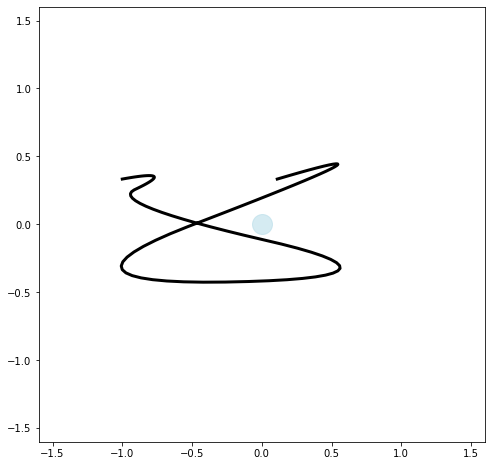

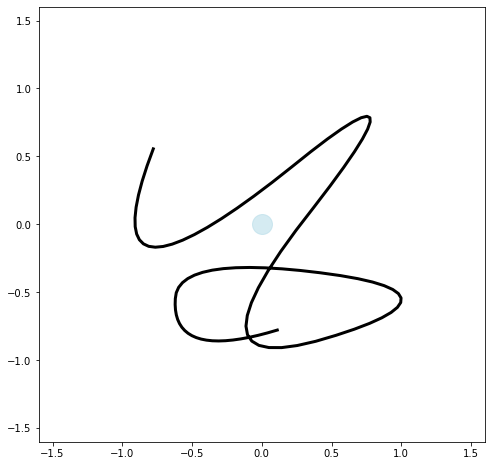

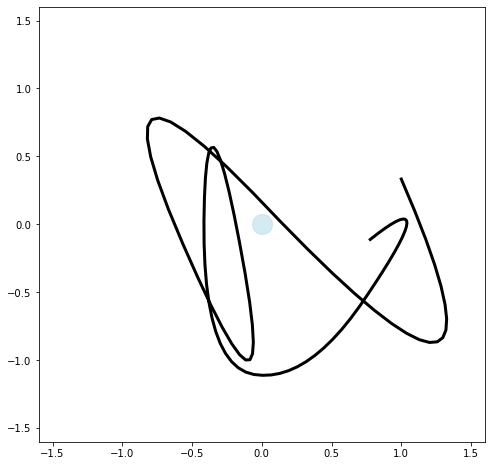

In [29]:
# plot the first curve of every complexity
for i, curve in enumerate(avg_curves):
    pretty_picture_of_curve(reshape(curve[0]), color='black')

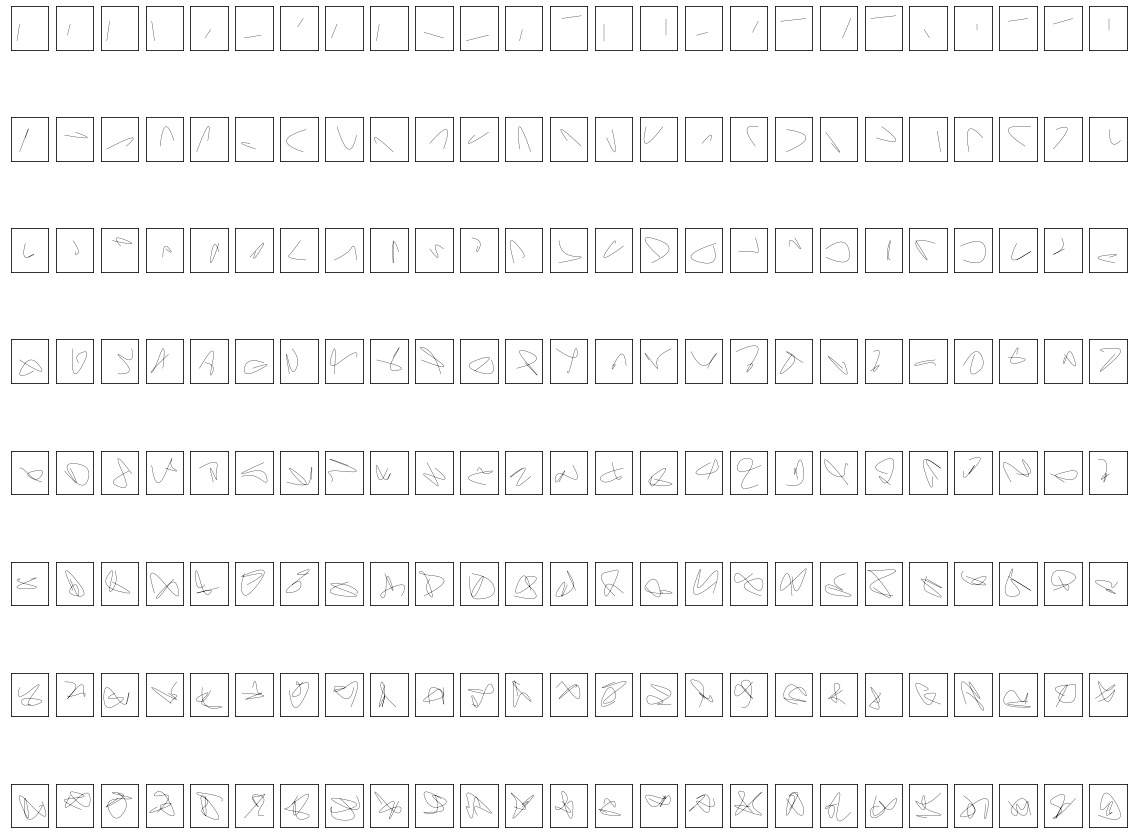

In [30]:
fig, ax = plt.subplots(8, n_curves_per_complexity)

for i,curves in enumerate(avg_curves):
    for j,c in enumerate(curves):
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        ax[i][j].set(xlim=[-1.75, 1.75], ylim=[-1.75, 1.75], aspect=1)
        pretty_picture_of_curve_ax(ax[i][j], reshape(c), color='black',width=3/10,plot_ref_points=False, dpi=800)
        
fig.set_size_inches(10*2, 8*2)
plt.show()

In [31]:
print('curves shape: ', np.array(avg_curves).shape)
print('distortions shape: ', np.array(avg_curves_distortions).shape)
print('avg distortions shape', np.array(average_distortions).shape)

curves shape:  (8, 25, 200)
distortions shape:  (8, 25, 200)
avg distortions shape (8, 200)


## hand select select target curves 

In [32]:
target_curve_selections = [
        [4, 9, 15, 22],
        [5, 9, 10, 23],
        [0, 1, 5, 10],
        [2, 8, 13, 15],
        [0, 8, 10, 19],
        [0, 21, 13, 23],
    ]

target_set = []
for c,s in zip(avg_curves, target_curve_selections):
    selection = np.array([c[i] for i in s])
    if len(selection) > 0:
        target_set.append(selection)
target_set = np.array(target_set)

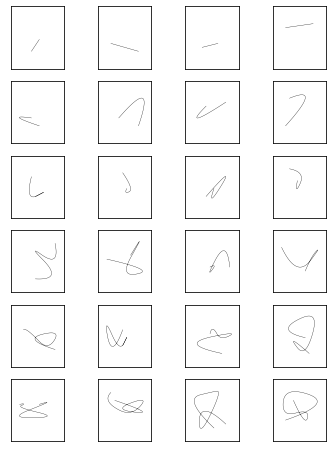

In [33]:
n_curves_per_complexity = 4
resolution_of_curves = 100

fig, ax = plt.subplots(6, n_curves_per_complexity)

for i,l in enumerate(target_set):
    for j,c in enumerate(l):
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        ax[i][j].set(xlim=[-1.75, 1.75], ylim=[-1.65, 1.65], aspect=1)
        pretty_picture_of_curve_ax(ax[i][j], reshape(c), color='black',width=3/10,plot_ref_points=False, dpi=800)
        
fig.set_size_inches(6, 8)
plt.show()

In [34]:
target_curves = []
for i in target_set:
    for j in i:
        target_curves.append(reshape(j))
target_curves = np.array(target_curves)
n_targets = len(target_curves)

In [35]:
# create curves directory
curves_path = output_path + '/curves'
if not os.path.exists(curves_path):
    print(f'making path: {curves_path}')
    os.mkdir(curves_path)

making path: ./online_pilot_007/curves


In [36]:
# save target curves
#np.savetxt(f'{curves_path}/target_curves.txt', target_curves, delimiter=',')
for i,c in enumerate(target_curves):
    np.savetxt(f'{curves_path}/curve_{i}.txt', c, delimiter=',')

In [37]:
from src.probes import generate_custom_probe_set_ext
from src.core import check_intersections

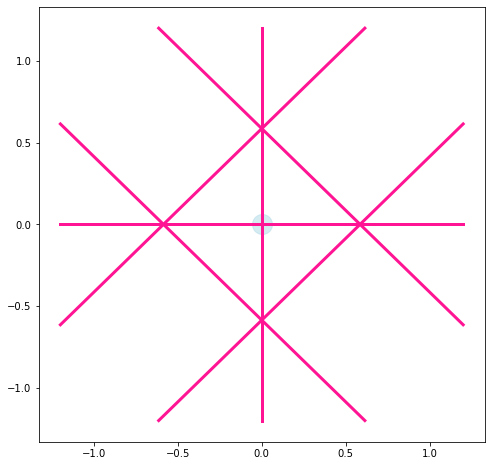

In [38]:
probe_curves = generate_custom_probe_set_ext(2, ext=.2)
n_probes = len(probe_curves)

In [39]:
n_isecs_array = np.ones((n_targets, n_probes)) * -1
for i, target in enumerate(target_curves):
    for j, probe in enumerate(probe_curves):
        _, n_isecs = check_intersections(target, probe)
        n_isecs_array[i][j] = n_isecs
        
n_isecs_array

array([[1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 2., 1.],
       [1., 2., 2., 1., 0., 1.],
       [1., 2., 1., 2., 1., 0.],
       [2., 1., 2., 1., 1., 0.],
       [2., 1., 0., 3., 1., 2.],
       [1., 1., 1., 0., 1., 0.],
       [3., 2., 2., 3., 0., 2.],
       [2., 2., 2., 0., 1., 0.],
       [3., 1., 1., 1., 2., 3.],
       [1., 2., 1., 1., 1., 2.],
       [3., 2., 1., 2., 0., 1.],
       [1., 3., 2., 0., 1., 3.],
       [3., 3., 2., 0., 1., 3.],
       [2., 3., 0., 5., 2., 0.],
       [3., 3., 2., 2., 0., 3.],
       [4., 2., 2., 2., 2., 3.],
       [3., 2., 2., 5., 3., 2.],
       [4., 4., 4., 0., 2., 4.],
       [4., 2., 2., 3., 2., 2.],
       [4., 3., 2., 3., 3., 4.]])

In [40]:
n_isecs_array.max()

5.0

## generate emperical distortion profile

In [48]:
from src.probes import generate_simple_probe_set
from src.rate_distortion import compute_rd_isecs

100%|██████████| 24/24 [56:11<00:00, 140.48s/it]


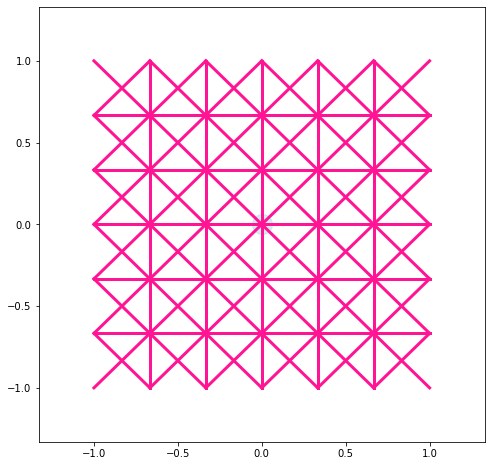

In [59]:
probe_curves = generate_simple_probe_set(7, border=False)
d = compute_rd_isecs(target_curves, pca, probe_curves, 'threshold', 'avg_ae')
np.savetxt(f'{dist_path}/distortion_isecs_threshold.txt', d, delimiter=',')

No handles with labels found to put in legend.


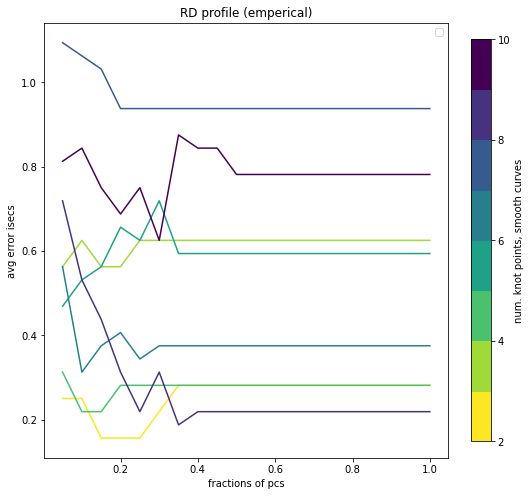

In [77]:
#d[:,1:].s
rd_plot(d[:,1:], max_knot_number, ylabel='avg error isecs', title='RD profile (emperical)')

In [ ]:
mean_distortions_projection = []
for i in range(0, len(d), 4):
    mean_distortions_projection.append(d[i:i+4].mean(axis=0))
    
mean_distortions_projection = np.array(m)
mean_distortions_projection.shape

In [61]:
d.shape

(24, 200)

100%|██████████| 24/24 [54:41<00:00, 136.71s/it]


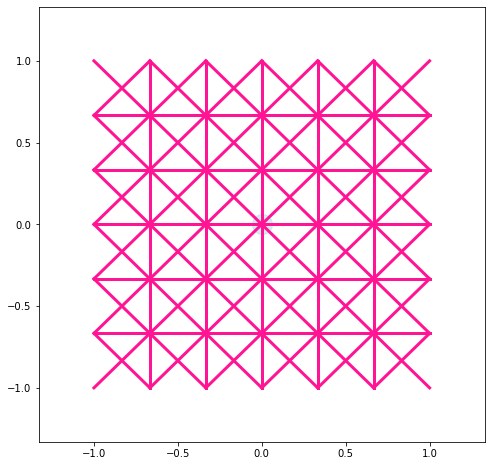

In [49]:
probe_curves = generate_simple_probe_set(7, border=False)
d = compute_rd_isecs(target_curves, pca, probe_curves, 'component', 'avg_ae')
np.savetxt(f'{dist_path}/distortion_isecs.txt', d, delimiter=',')

No handles with labels found to put in legend.


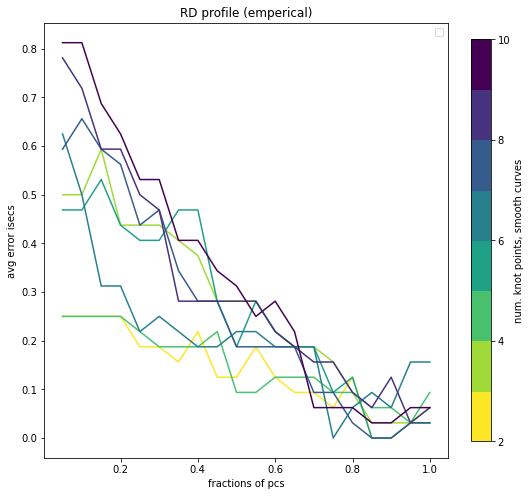

In [51]:
rd_plot(d, max_knot_number, ylabel='avg error isecs', title='RD profile (emperical)')

No handles with labels found to put in legend.


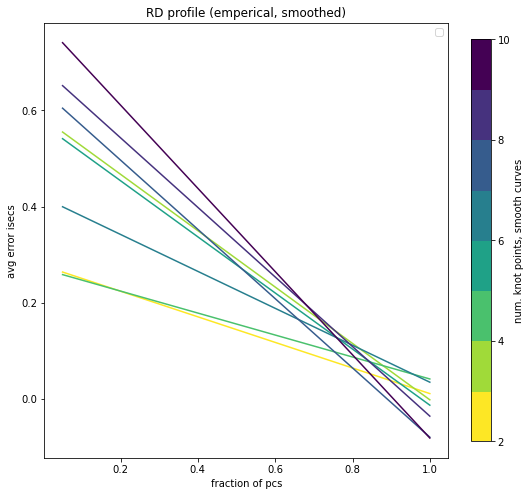

In [54]:
_ = smooth_distortions(d, max_knot_number, 1, ylabel='avg error isecs', title='RD profile (emperical, smoothed)')

100%|██████████| 24/24 [10:15<00:00, 25.66s/it]
No handles with labels found to put in legend.


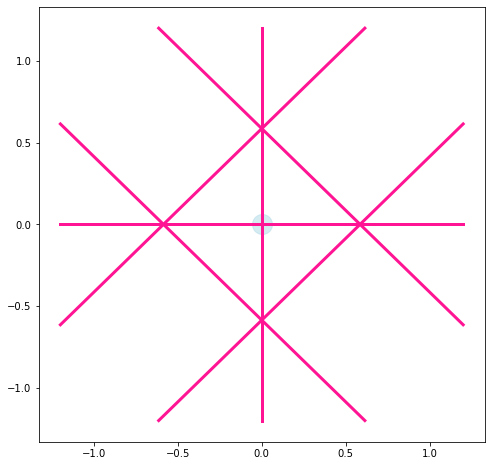

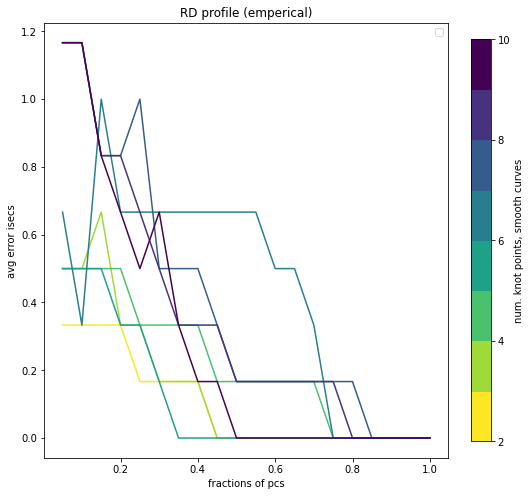

In [56]:
probe_curves = generate_custom_probe_set_ext(2, ext=.2)
d = compute_rd_isecs(target_curves, pca, probe_curves, 'component', 'avg_ae')
np.savetxt(f'{dist_path}/distortion_isecs_2.txt', d, delimiter=',')
rd_plot(d, max_knot_number, ylabel='avg error isecs', title='RD profile (emperical)')

No handles with labels found to put in legend.


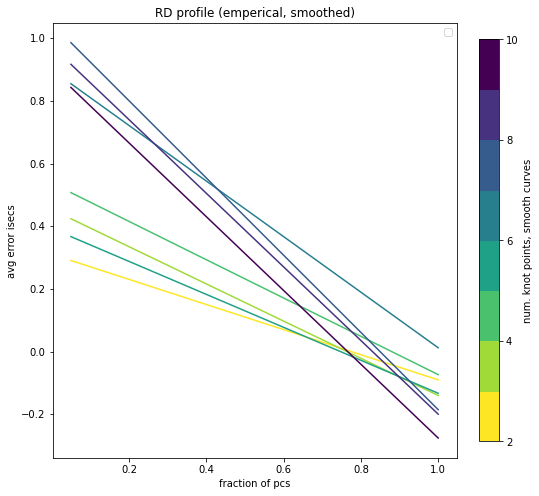

In [57]:
_ = smooth_distortions(d, max_knot_number, 1, ylabel='avg error isecs', title='RD profile (emperical, smoothed)')

In [58]:
d.shape

(24, 200)

In [ ]:
#probe_curves = generate_simple_probe_set(25, border=False)
#d = compute_rd_isecs(target_curves, pca, probe_curves, 'component', 'avg_ae')
#np.savetxt(f'{dist_path}/distortion_isecs.txt', d, delimiter=',')#

## create conditions file

In [41]:
import random
from src.core import check_intersections

In [42]:
def get_exp_time(n_targets, n_probes, target_duration, probe_duration, target_presentation_rate, n_breaks, break_time, isi=2):
    n_trials = n_targets * n_probes
    #assert(n_targets % (n_breaks+1) == 0)
    #assert(n_probes % target_presentation_rate == 0)
    probe_presentation = n_probes * (probe_duration + isi)
    target_presentation = ((n_probes / target_presentation_rate) * target_duration)
    time_per_target = target_presentation + probe_presentation
    exp_time = (n_targets * time_per_target)
    break_time = (n_breaks * break_time)
    print('===== experiment time =====')
    print(f'  n_trials: {n_trials}')
    print(f'  total time: {(exp_time+break_time) / 60} min')
    print(f'  time per sections: {exp_time / (n_breaks+1) / 60 }')

In [43]:
target_duration = 5 
probe_duration = 2.5
target_presentation_rate = 2
isi = .5
n_breaks = 2
break_time = 60
n_trials = n_probes * n_targets

get_exp_time(n_targets, n_probes+2, target_duration, 
             probe_duration, target_presentation_rate, 
             isi=2, n_breaks=n_breaks, break_time=break_time)

===== experiment time =====
  n_trials: 192
  total time: 24.4 min
  time per sections: 7.466666666666667


In [44]:
#n_isecs_array = np.ones((n_targets, n_probes)) * -1
#for i, target in enumerate(target_curves):
#    for j, probe in enumerate(probe_curves):
#        _, n_isecs = check_intersections(target, probe)
#        n_isecs_array[i][j] = n_isecs
        
#n_isecs_array

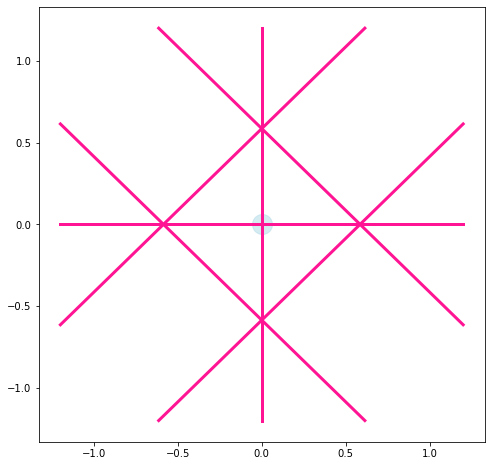

In [45]:
probe_curves = generate_custom_probe_set_ext(2, ext=.2)
n_probes = len(probe_curves)

In [46]:
target_curves[0].shape

(100, 2)

In [47]:
# helpers
def shuffle(conditions_list):
    while(adjacent(get_target_ids(conditions_list))):
        random.shuffle(conditions_list)
    return conditions_list

def adjacent(ids):
    for i in range(len(ids)-1):
        if ids[i] == ids[i+1]:
            return True
    return False

def get_target_ids(conditions):
    return [df['target_id'].values[0] for df in conditions]

In [48]:
path = './resources'

# create conditions file
conditions_list = []
for i, target in enumerate(target_curves):
    # create mini-conditions for each target curve
    # the split them into 'blocks' according to some presentation rate
    target_id, probe_id = [],[]
    target_img, probe_img, isecs_img = [],[],[]
    n_isecs, isecs, target_complexity, probe_complexity = [],[],[],[]
    for j, probe in enumerate(probe_curves):
        ix, n = check_intersections(target, probe)
        target_id.append(i)
        probe_id.append(j)
        n_isecs.append(n)
        isecs.append(ix)
        target_complexity.append((i // n_curves_per_complexity) + 2)
        probe_complexity.append(2) # all probes are complexity 2 
        target_img.append(f'{path}/curve_{i}_black.png')
        probe_img.append(f'{path}/curve_{j}_pink.png')
        isecs_img.append(f'{path}/isecs_{i}_{j}.png')
        
    # randomly select 2 repeats
    repeat_ids = np.random.choice(np.arange(len(probe_curves)), size=2, replace=False)
    repeat_probes = [probe_curves[i] for i in repeat_ids]
    for pid, probe in zip(repeat_ids, repeat_probes):
        ix, n = check_intersections(target, probe)
        target_id.append(i)
        probe_id.append(pid)
        n_isecs.append(n)
        isecs.append(ix)
        target_complexity.append((i // n_curves_per_complexity) + 2)
        probe_complexity.append(2) # all probes are complexity 2 
        target_img.append(f'{path}/curve_{i}_black.png')
        probe_img.append(f'{path}/curve_{pid}_pink.png')
        isecs_img.append(f'{path}/isecs_{i}_{pid}.png')

    conditions = {
        'target_file': target_img,
        'probe_file': probe_img,
        'n_isecs': n_isecs,
        'target_id': target_id,
        'probe_id': probe_id,
        'target_complexity': target_complexity,
        'probe_complexity': probe_complexity,
        'isecs_image': isecs_img
    }
    # shuffle each mini-batch 
    conditions_df = pd.DataFrame(data=conditions).sample(frac=1).reset_index(drop=True)
    # make sure probes are not adjacent to each other
    while(adjacent(conditions_df.probe_id.values)):
        conditions_df = conditions_df.sample(frac=1).reset_index(drop=True)
    # split into blocks at some presentation rate
    split_dfs=[]
    for i in range(0, len(conditions_df), target_presentation_rate):
        split_dfs.append(conditions_df.iloc[i:i+target_presentation_rate,:])
    for df in split_dfs:
        conditions_list.append(df)

In [49]:
conditions_list = shuffle(conditions_list)
df = pd.concat(conditions_list).reset_index(drop=True)

In [50]:
break_rate = int(n_trials / (n_breaks+1))
print(f'break_rate: {break_rate}')

break_rate: 48


In [51]:
break_rate = int(n_trials / (n_breaks+1))
show_break = [1 if (i+1)%break_rate==0 else 0 for i in range(len(df))]
show_target = [1 if i%target_presentation_rate==0 else 0 for i in range(len(df))]
show_break[-1] = 0
df['show_break'] = show_break
df['show_target'] = show_target

In [52]:
df

,target_file,probe_file,n_isecs,target_id,probe_id,target_complexity,probe_complexity,isecs_image,show_break,show_target
0,./resources/curve_19_black.png,./resources/curve_5_pink.png,2,19,5,6,2,./resources/isecs_19_5.png,0,1
1,./resources/curve_19_black.png,./resources/curve_1_pink.png,2,19,1,6,2,./resources/isecs_19_1.png,0,0
2,./resources/curve_1_black.png,./resources/curve_4_pink.png,0,1,4,2,2,./resources/isecs_1_4.png,0,1
3,./resources/curve_1_black.png,./resources/curve_0_pink.png,0,1,0,2,2,./resources/isecs_1_0.png,0,0
4,./resources/curve_3_black.png,./resources/curve_4_pink.png,1,3,4,2,2,./resources/isecs_3_4.png,0,1
...,...,...,...,...,...,...,...,...,...,...
187,./resources/curve_14_black.png,./resources/curve_1_pink.png,2,14,1,5,2,./resources/isecs_14_1.png,0,0
188,./resources/curve_6_black.png,./resources/curve_4_pink.png,2,6,4,3,2,./resources/isecs_6_4.png,0,1
189,./resources/curve_6_black.png,./resources/curve_5_pink.png,0,6,5,3,2,./resources/isecs_6_5.png,0,0
190,./resources/curve_13_black.png,./resources/curve_5_pink.png,2,13,5,5,2,./resources/isecs_13_5.png,0,1


## save out stimuli / resources

In [53]:
output_path

'./online_pilot_005'

In [54]:
resources_path = output_path + '/resources'
if not os.path.exists(resources_path):
    print(f'making path: {resources_path}')
    os.mkdir(resources_path)

In [55]:
df.to_csv(resources_path + '/conditions_df.csv', index=False)

In [56]:
def save_stimuli(targets, probes, path):
    for i,t in enumerate(targets):
        pretty_picture_of_curve(t, color='black', write_to=f'{path}/curve_{i}_black.png', show=False)

    for i,p in enumerate(probes):
        pretty_picture_of_curve(p, color='deeppink', write_to=f'{path}/curve_{i}_pink.png', show=False, ref_point_color='red')
    
    #pretty_picture_of_curve(targets, color=['black' for _ in range(len(targets))], write_to=f'{path}/plots/all_curves.png', show=False)
    for i, c1 in enumerate(targets):
        for j, c2 in enumerate(probes):
            if i != j:
                isecs, n_isecs = check_intersections(c1, c2) 
                pretty_picture_of_curve([c1,c2], color=['black', 'deeppink'], write_to=f'{path}/isecs_{i}_{j}.png', isecs=isecs, ref_point_color='red', show=False) 

In [57]:
save_stimuli(target_curves, probe_curves, resources_path)

In [58]:
# generate stock images 
pretty_picture_of_curve([], write_to=resources_path + '/blank.png', show=False) 
pretty_picture_of_curve([], ref_point_color='red', write_to=resources_path + '/blank_red.png', show=False) 

## generate practice loop

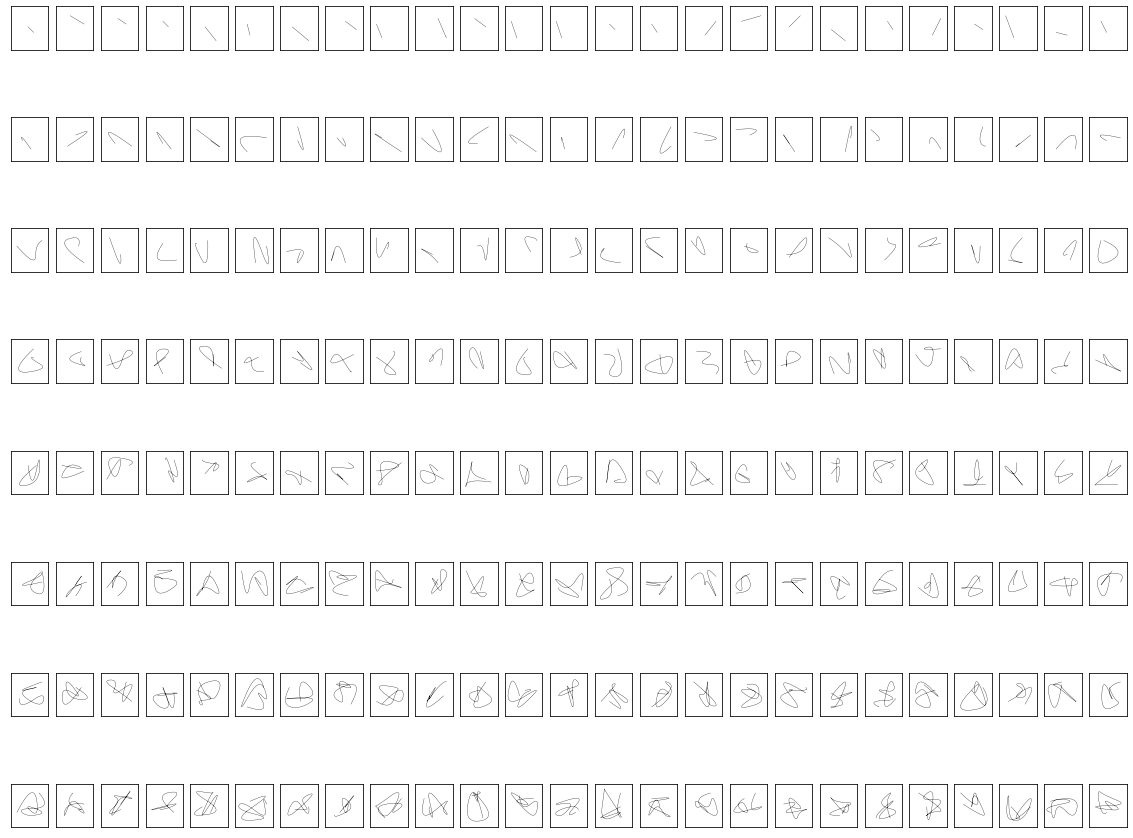

In [59]:
fig, ax = plt.subplots(8, 25)

for i,curves in enumerate(avg_curves):
    for j,c in enumerate(curves):
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        ax[i][j].set(xlim=[-1.5, 1.5], ylim=[-1.5, 1.5], aspect=1)
        pretty_picture_of_curve_ax(ax[i][j], reshape(c), color='black',width=3/10,plot_ref_points=False, dpi=800)
        
fig.set_size_inches(10*2, 8*2)
plt.show()

In [60]:
practice_curve_selections = [
        [4],
        [9],
        [0]
    ]

practice_set = []
for c,s in zip(avg_curves, practice_curve_selections):
    selection = np.array([c[i] for i in s])
    if len(selection) > 0:
        practice_set.append(selection)
practice_set = np.array(practice_set)

In [61]:
practice_set.shape

(3, 1, 200)

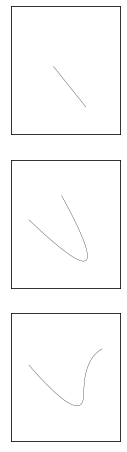

In [62]:
n_curves_per_complexity = 1
resolution_of_curves = 100

fig, ax = plt.subplots(3, n_curves_per_complexity)

for i,l in enumerate(practice_set):
    for j,c in enumerate(l):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set(xlim=[-1.5, 1.5], ylim=[-1.5, 1.5], aspect=1)
        pretty_picture_of_curve_ax(ax[i], reshape(c), color='black',width=3/10,plot_ref_points=False, dpi=800)
        
fig.set_size_inches(6, 8)
plt.show()

In [63]:
practice_target_curves = []
for i in practice_set:
    for j in i:
        practice_target_curves.append(reshape(j))
practice_target_curves = np.array(practice_target_curves)
n_practice_targets = len(practice_target_curves)

In [64]:
practice_target_curves[0].shape

(100, 2)

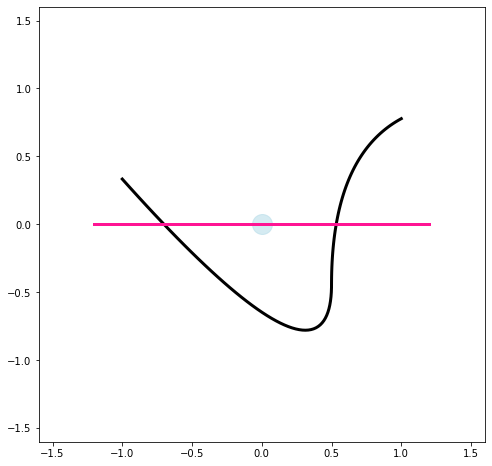

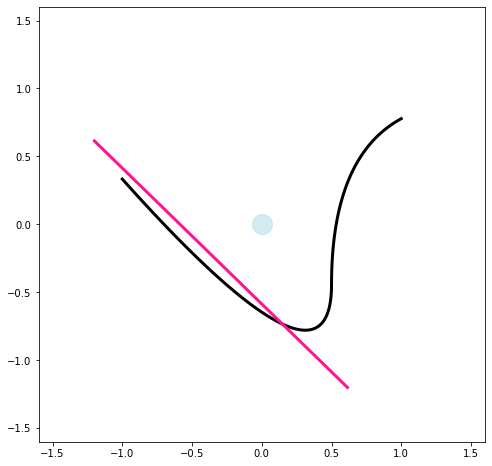

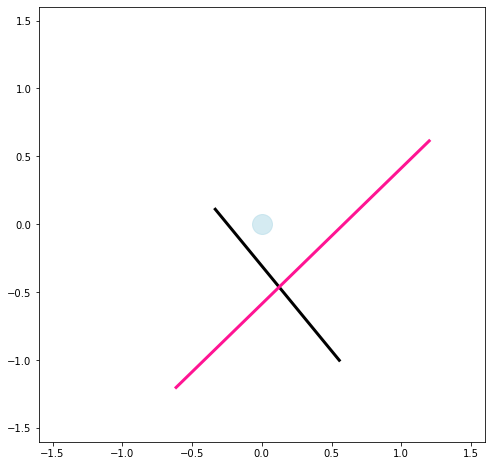

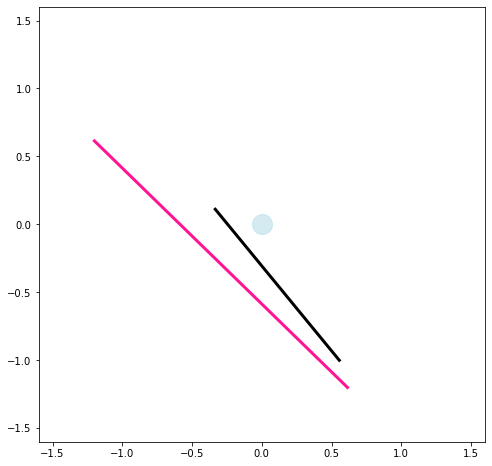

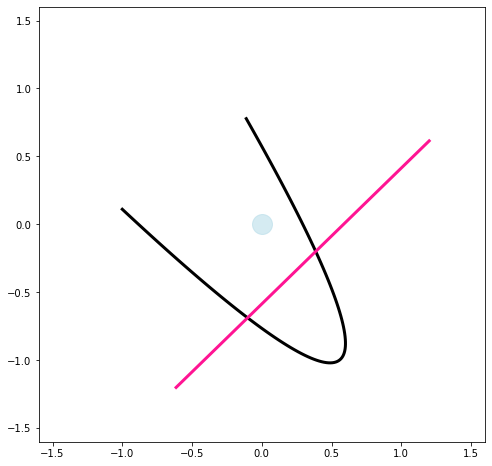

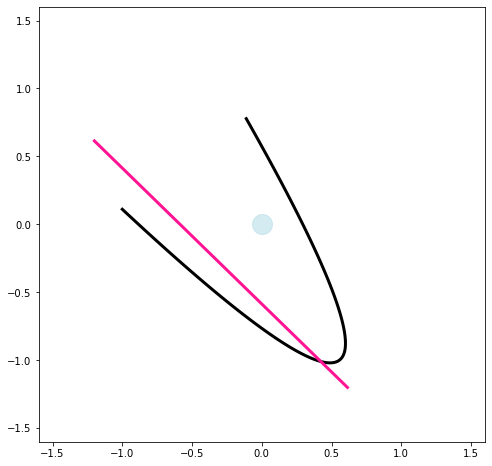

In [85]:
practice_target_ids = [2, 2, 0, 0, 1, 1]
practice_probe_ids = [1, 3, 5, 3, 5, 3]

pp = [probe_curves[i] for i in practice_probe_ids]
pt = [practice_target_curves[i] for i in practice_target_ids]
for p,t in zip(pp, pt):
    pretty_picture_of_curve([t, p], color=['black', 'deeppink']) 

In [86]:
path = './resources'

#practice_probe_ids = [0, 3, 2]
#practice_probe_curves = [probe_curves[i] for i in practice_probe_ids]
practice_conditions_list = []
target_id, probe_id = [],[]
target_img, probe_img, isecs_img = [],[],[]
n_isecs, isecs, target_complexity, probe_complexity = [],[],[],[]
for i, (probe, target) in enumerate(zip(pp, pt)):
    ix, n = check_intersections(target, probe)
    t_id = n_targets + (i // 2)
    p_id = practice_probe_ids[i]
    t_img = path + f'/curve_{t_id}_black.png'
    p_img = path + f'/curve_{p_id}_pink.png'
    i_img = path + f'/practice_isecs_{t_id}_{p_id}.png'
    
    pretty_picture_of_curve(target, color='black', write_to=f'{output_path}/{t_img}', show=False)
    pretty_picture_of_curve([target, probe], color=['black', 'deeppink'], isecs=ix, write_to=f'{output_path}/{i_img}', ref_point_color='red', show=False) 
    
    n_isecs.append(n)
    target_id.append(t_id)
    probe_id.append(p_id)
    target_img.append(t_img)
    probe_img.append(p_img)
    isecs_img.append(i_img)
    target_complexity.append(i + 2)
    probe_complexity.append(2) # all probes are complexity 2 
    
practice_conditions = {
    'target_file': target_img,
    'probe_file': probe_img,
    'n_isecs': n_isecs,
    'target_id': target_id,
    'probe_id': probe_id,
    'target_complexity': target_complexity,
    'probe_complexity': probe_complexity,
    'isecs_image': isecs_img
}

practice_conditions_df = pd.DataFrame(practice_conditions)

In [87]:
practice_conditions_df['show_target'] = [1, 0, 1, 0, 1, 0]

In [88]:
practice_conditions_df.to_csv(resources_path + '/practice_conditions_df.csv', index=False)

In [89]:
practice_conditions_df

,target_file,probe_file,n_isecs,target_id,probe_id,target_complexity,probe_complexity,isecs_image,show_target
0,./resources/curve_24_black.png,./resources/curve_1_pink.png,2,24,1,2,2,./resources/practice_isecs_24_1.png,1
1,./resources/curve_24_black.png,./resources/curve_3_pink.png,1,24,3,3,2,./resources/practice_isecs_24_3.png,0
2,./resources/curve_25_black.png,./resources/curve_5_pink.png,1,25,5,4,2,./resources/practice_isecs_25_5.png,1
3,./resources/curve_25_black.png,./resources/curve_3_pink.png,0,25,3,5,2,./resources/practice_isecs_25_3.png,0
4,./resources/curve_26_black.png,./resources/curve_5_pink.png,2,26,5,6,2,./resources/practice_isecs_26_5.png,1
5,./resources/curve_26_black.png,./resources/curve_3_pink.png,1,26,3,7,2,./resources/practice_isecs_26_3.png,0
